# Vector Data (`geopandas`)

> This page is a Jupyter Notebook that can be [found and downloaded at the GitHub repository](https://github.com/trchudley/geospatial-python-durham/blob/main/website/02_using/03a_vector_data.ipynb).

## Introducing Geopandas

The primary way we interact with vector data (`.gpkg`, `.shp`, `.geojson`, `.geoparquet`, etc. etc.) is via the `geopandas` package. This does what it sounds like - its `pandas`, but with additional functionality in the form of a `geometry` column and associated metadata that allows it to store vector geospatial information!

In [ ]:
import geopandas as gpd

# Also we'll need matplotlib for this notebook
import matplotlib.pyplot as plt

As with everything in this documentation, [GeoPandas has its own extensive documentation and examples](https://geopandas.org/en/stable/getting_started/introduction.html), which you can either explore at your leisure or bit-by-bit as you need more functionality and you discover them through googling or LLMing assistance!

However, here's a brief series of examples of how you might use it. First, we can point it to any reasonable vector file (here a `.geojson`), and it should be able to read it:

In [2]:
# Load a pre-existing map of Europe
europe_gdf = gpd.read_file('https://raw.githubusercontent.com/leakyMirror/map-of-europe/refs/heads/master/GeoJSON/europe.geojson')

Note the `gdf` in the variable name, which is useful shorthand to indicate you have a Geo(pandas) DataFrame. We can visualise this as with Pandas:

In [3]:
# Using `.head()` will limit what is shown to just the first 5 rows, useful for 
# sanity checking a long dataset
europe_gdf.head()

FID FIPS ISO2 ISO3   UN                    NAME   AREA  POP2005  REGION  \
0  0.0   AJ   AZ  AZE   31              Azerbaijan   8260  8352021     142   
1  0.0   AL   AL  ALB    8                 Albania   2740  3153731     150   
2  0.0   AM   AM  ARM   51                 Armenia   2820  3017661     142   
3  0.0   BK   BA  BIH   70  Bosnia and Herzegovina   5120  3915238     150   
4  0.0   BU   BG  BGR  100                Bulgaria  11063  7744591     150   

   SUBREGION     LON     LAT  \
0        145  47.395  40.430   
1         39  20.068  41.143   
2        145  44.563  40.534   
3         39  17.786  44.169   
4        151  25.231  42.761   

                                            geometry  
0  MULTIPOLYGON (((45.08332 39.76804, 45.26639 39...  
1  POLYGON ((19.43621 41.02106, 19.45055 41.06, 1...  
2  MULTIPOLYGON (((45.57305 40.63249, 45.52888 40...  
3  POLYGON ((17.64984 42.88908, 17.57853 42.94382...  
4  POLYGON ((27.87917 42.8411, 27.895 42.8025, 27...

The most important thing is the `geometry` column on the far right. This is the magic geospatial data that allows us to visualise it! 

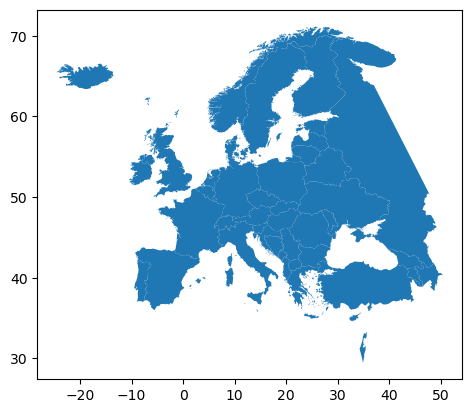

In [4]:
europe_gdf.plot()
plt.show()

Note that just `.plot()` on the dataset will do a very simple matplotlib plot of the dataset. Things can get more complicated by using parameters, or by using `fig, ax = plt.subplots()` and `ax=ax` as a parameter within `.plot()`, we can begin to combine it with other datasets. I will do this later in the notebook.

## Manipulating Datasets

We have all the same functionality as pandas in terms of processing and indexing.

The lat/lon boundaries of the UK are: [-8.62139  49.911659  1.74944  60.844444].
It has a total 2005 population of 60244834


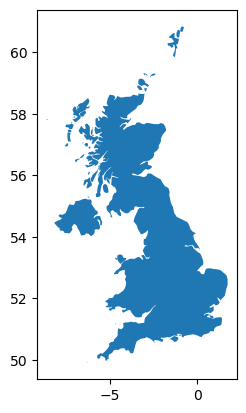

In [5]:
uk_gdf = europe_gdf[europe_gdf['NAME'] == 'United Kingdom']

print(f'The lat/lon boundaries of the UK are: {uk_gdf.total_bounds}.')
print(f'It has a total 2005 population of {uk_gdf['POP2005'].item()}')

uk_gdf.plot()
plt.show()

As you might be able to tell from the `x` and `y` axis values, we're probably dealing with a dataset in latitude and longitude. If you have a suitable filetype that included this metadata, we can check the `crs` variable to make sure:

In [6]:
europe_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Yup! We can also convert between different CRS formats by providing the EPSG code. This is especially important if we want to start working with area/length measurements, as we want to ensure are units are in metres.

Most commonly, we will probably want to move into Polar Stereographic North (EPSG:3413) and south (EPSG:3031).

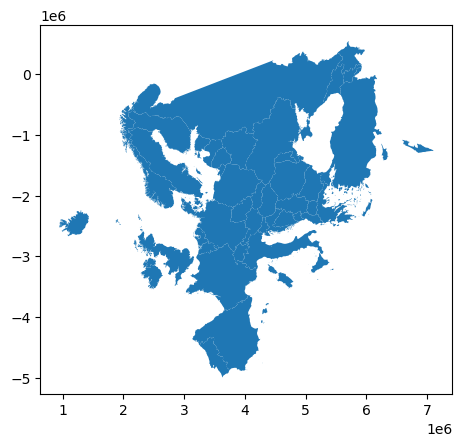

In [7]:
europe_gdf_polarstereographic = europe_gdf.to_crs(epsg=3413)

europe_gdf_polarstereographic.plot()
plt.show()

It is worth noting that GeoPandas gets its geographic geometry functionality from a base package called `shapely`. You can import these geometries (`Point`, `LineString`, `Polygon`) and create your own files if you like!

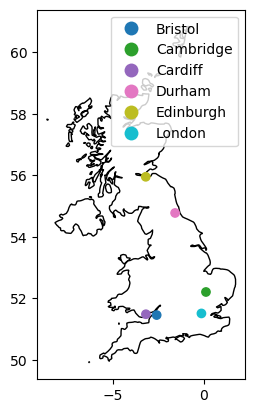

In [8]:
from shapely.geometry import Point

names = ["Durham", "Cambridge", "London", "Bristol", "Edinburgh", "Cardiff"]
lats = [54.7761, 52.2053, 51.5074, 51.4545, 55.9533, 51.4816]
lons = [-1.5755, 0.1218, -0.1278, -2.5879, -3.1883, -3.1791]

# Construct points list with loop
points = []
for lat, lon in zip(lats, lons):
    points.append(Point(lon, lat))  # Shapely Point expects (lon, lat)

# Create DataFrame from the lists. Columns can be presented as a dictionary
cities_df = gpd.GeoDataFrame(
    {"city": names, "lat": lats, "lon": lons},
    geometry=points,
    crs=4326
    )

fig, ax = plt.subplots()
uk_gdf.plot(ax=ax, fc='none', ec='black')  # fc: facecolor; ec: edgecolor
cities_df.plot(ax=ax, column="city", legend=True)
plt.show()

For remote sensing analysis, it is particularly useful to know the `box` function of shapely. This allows you to create rectangular polygons from just the bounding box (e.g. `[xmin, ymin, xmax, ymax]`). You can then use this for clipping datasets, including rasters!

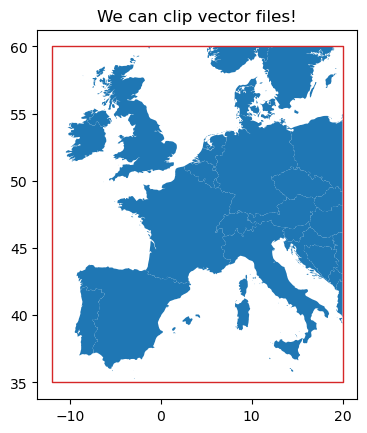

In [9]:
from shapely.geometry import box

# Define shapely bbox
western_europe_bbox = box(-12, 35, 20, 60)

# Create geopandas GeoDataFrame of bbox
bbox_gdf = gpd.GeoDataFrame(geometry=[western_europe_bbox], crs=4326)

# Clip europe_gdf to bbox
western_europe_gdf = europe_gdf.clip(bbox_gdf)


fig, ax = plt.subplots()
western_europe_gdf.plot(ax=ax)
bbox_gdf.plot(ax=ax, fc='none', ec='tab:red')
ax.set_title('We can clip vector files!')
plt.show()